In [1]:
import pandas as pd

1. Загрузка и первичный осмотр

In [2]:
file = "S02-hw-dataset.csv"
df = pd.read_csv(file)

In [3]:
df.head(10)

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296
5,6,120.0,FR,-1,785
6,7,46.0,RU,0,0
7,8,28.0,CN,2,456
8,9,39.0,US,4,980
9,10,24.0,RU,7,511


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [5]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


2. Пропуски, дубликаты и базовый контроль качества

In [6]:
df.isna().mean()

user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

In [7]:
df.isna().sum()

user_id      0
age          2
country      0
purchases    0
revenue      0
dtype: int64

In [8]:
duplicates = sum(df.duplicated())
duplicates

1

In [9]:
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511


In [10]:
#Нереалистичный возраст (> 100 лет)
unrealistic_age = df[df['age'] > 100]
print(unrealistic_age)

   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785


In [11]:
#Нереалистичный возраст (< 0 лет)
unrealistic_age = df[df['age'] <= 0]
print(unrealistic_age)

Empty DataFrame
Columns: [user_id, age, country, purchases, revenue]
Index: []


In [12]:
unrealistic_revenue = df[(df['revenue'] <= 0) & (df['purchases'] > 0)]
print(unrealistic_revenue)

    user_id   age country  purchases  revenue
10       11  24.0      US          4        0


In [13]:
#отрицательные покупки
unreal_purchases = df[df['purchases'] < 0]
unreal_purchases

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


Обнаружены следующие проблемы качеста.
Пропущенные значения в признаке возраст: 2 строки.
Одинаковые строки: 2 строки.
Большой возраст пользоватеся и отрицетельные покупки: 1 строка.
При нулевом доходе имеются покупки: 1 строка. 

3. Базовый EDA: группировки, агрегаты и частоты

In [14]:
# 1. частоты для одной или двух категориальных переменных
freq_country = df['country'].value_counts()
freq_country

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

In [15]:
# 2. группировка с агрегатами через groupby
group_stats = df.groupby('country').agg({
    'purchases': ['mean', 'sum'],
    'revenue': ['mean', 'sum']
})
group_stats

purchases          revenue       
             mean sum         mean    sum
country                                  
CN       4.500000   9  1054.000000   2108
DE       6.500000  39  1445.500000   8673
FR       4.250000  51   675.916667   8111
RU       4.769231  62   790.076923  10271
US       4.625000  37   557.375000   4459

In [16]:
# 3. «коридоры» (bins) или группировки (например, возрастные группы, диапазоны значений и т.п.) - Разбивка на интервалы
age_bins = pd.cut(df['age'], bins=[0,18,35,50,70,200], labels=['0-18','19-35','36-50','51-70','70+'])
age_group_stats = df.groupby(age_bins, observed=True).agg({
    'purchases':'mean',
    'revenue':'mean'
})
print(age_group_stats)

       purchases      revenue
age                          
0-18    6.000000  1296.000000
19-35   4.952381   772.904762
36-50   4.222222   945.333333
51-70   5.000000   596.666667
70+    -1.000000   785.000000


Чаще всего встречаются записи из RU и FR. 
DE заметно обгоняет остальных по средним и суммарным показателям дохода (revenue).
Возрастная группа 0–18 с самыми высокими средними покупками и доходом.

#### Визуализация данных в Matplotlib

In [59]:
import matplotlib.pyplot as plt
import os
outdir = './figures'

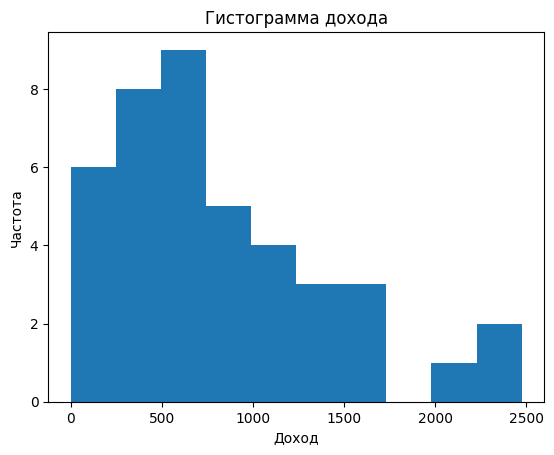

In [60]:
# 1 Гистограмма дохода (revenue)
plt.figure()
plt.hist(df['revenue'].dropna(), bins=10)
plt.xlabel("Доход")
plt.ylabel("Частота")
plt.title("Гистограмма дохода")
hist_path = os.path.join(outdir, 'hist_revenue.png')
plt.savefig(hist_path)
plt.show()

<Figure size 640x480 with 0 Axes>

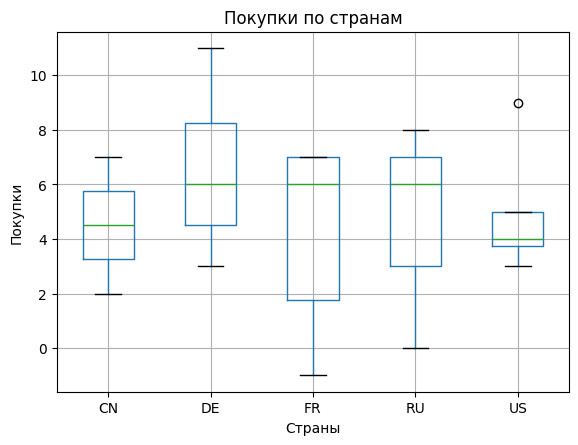

In [61]:
# 2 Боксплот покупки по странам - boxplot purchases by country
plt.figure()
df.boxplot(column='purchases', by='country')
plt.xlabel("Страны")
plt.ylabel("Покупки")
plt.title("Покупки по странам")
plt.suptitle("")
box_path = os.path.join(outdir, 'box_purchases_country.png')
plt.savefig(box_path)
plt.show()

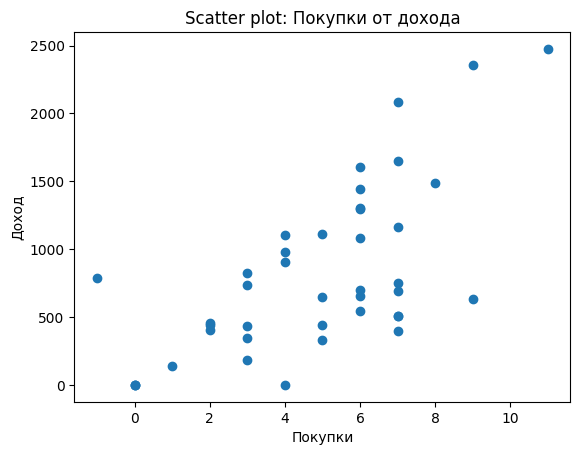

In [62]:
# 3 диаграмма рассеяния - scatter plot purchases vs revenue
plt.figure()
plt.scatter(df['purchases'], df['revenue'])
plt.xlabel("Покупки")
plt.ylabel("Доход")
plt.title("Scatter plot: Покупки от дохода")
scatter_path = os.path.join(outdir, 'scatter_purchases_revenue.png')
plt.savefig(scatter_path)
plt.show()